# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Открытие файла с данными и изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime

In [2]:
estate_data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [4]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [5]:
estate_data.duplicated().value_counts()

False    23699
dtype: int64

### Вывод

В базе данных содержится 23699 записей, большим количеством пропусков (особенно выделяется столбец 'is_apartment', в котором данные присутствуют только для 2775 записей. Исследование причин пропусков и попытка их обработки будет выполнена в шаге 2). Так же наблюдаются проблемы с типами данных (например столбец с количеством балконов имеет тип данных float64, который необходимо заменить на целочисленный)

### Шаг 2. Предобработка данных

#### 2.1. Обработка пропущеных значений

- **Первый столбец с пропущенными значениями ['ceiling_height'] описывает высоту потолков.**

In [6]:
estate_data['ceiling_height'].isna().mean()

0.38799105447487237

Вероятно, многие люди, выкладывающие объявления о продаже квартиры, совершенно не представляют высоту своих потолков. Практически в 38% записей она не указана.   
Вопрос о влиянии высоты потолков в задачи анализа не входит, так что этот пункт можно проигнорировать, однако можем заменить эти значения на наиболее характерные. По СНиП 31-01-2003 минимальная высота потолка в жилом помещении - 2,5 м. Для типовых домов советских времен высота потолков варировалась в диапазоне 2,5-2,7. Проверим, соответствуют ли квартиры из нашей выборки этим значениям, посчитав медиану.

In [7]:
estate_data['ceiling_height'].median()

2.65

Похоже на правду. ~~Заполним пропущенные значения медианой с помощью метода .fillna()~~ Не будем этого делать, так-как данные этого столбца используются для построения графиков, и отстутствующие значения нам не помешают, а вот неистиные очень даже.

In [8]:
# estate_data['ceiling_height'].fillna(estate_data['ceiling_height'].median(), inplace=True)

- **Второй столбец с пропущенными значениями 'floors_total' описывает количество этажей дома**

Посмотрим на записи, в которых пропущены значения этого столбца.

In [9]:
estate_data[estate_data['floors_total'].isna()].head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


In [10]:
len(estate_data[estate_data['floors_total'].isna()])

86

In [11]:
estate_data[estate_data['floors_total'].isna()]['floor'].count()

86

Таких записей, в целом, немного, и этаж для каждой из них указан (а жаль, можно было бы предположить что все это подземные бункеры...)  
Мы точно знаем, что номер этажа на котором находится квартира не превышает общее количество этажей в доме. Но обратим внимание на то, что нам необходимо будет вычислить, является ли этаж последним. Поэтому просто заменив эти значения мы внесем эту несуществующую информацию в датасет. Поэому проигнорируем данные пропуски и оставим все как есть. 

Кстати, данный столбец имеет тип float, что не является необходимым ввиду отсутствия дробных этажей. Это будет исправлено на шаге 2.2.

In [12]:
(estate_data['floors_total'] < estate_data['floor']).mean()

0.0

Квартир, находящихся выше, чем это позволяет высота дома в выборке нет.

- **Следующий столбец - living_area, жилая площадь.**

Посмотрим, если ли возможность вычилсить жилую площадь по данным других столбцов. Достаточно точную оценку жилой площади можно получить, если отнять из общей площади площадь кухни (хотя при этом не учитывается площадь коридоров, балконов и т.д.)

In [13]:
len(estate_data[estate_data['living_area'].isna()])

1903

In [14]:
estate_data[estate_data['living_area'].isna()]['total_area'].count()

1903

In [15]:
estate_data[estate_data['living_area'].isna()]['kitchen_area'].count()

439

К сожалению не для всех записей это возможно. В 439 из них пропущены одновременно и жилая площадь, и площадь кухни. Исправим то, что есть, а остальное проигнорируем, так как данные столбцы в анализе не используются 

<details>
  <summary>Спойлер</summary>
  <p>
      Можно было бы оценить площадь кухни, как характерную для типовых домов с заданой полной площадью, но это все равно не работает если пропущена и площадь кухни и жилая. 

In [16]:
estate_data['living_area'].fillna(estate_data['total_area']-estate_data['kitchen_area'], inplace = True)

In [17]:
len(estate_data[estate_data['living_area'].isna()])

1464

Аналогично поступим и с пропущенными значениями площади кухни.

In [18]:
len(estate_data[estate_data['kitchen_area'].isna()])

2278

In [19]:
estate_data['kitchen_area'].fillna(estate_data['total_area']-estate_data['living_area'], inplace = True)

In [20]:
len(estate_data[estate_data['kitchen_area'].isna()])

1464

В итоге у нас осталось 1464 записей с одновременно отсутствующими значениями для жилой площади и площади кухни.

- **Самый неудачный столбец is_apartment**

In [21]:
estate_data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Как видно, если судить по заполненным столбцам - большинство квартир не является апартаментами. Это в целом соответствует ситуации на петербургском рынке недвижимости (хотя со временем количество апартаментов и увеличивается):  
https://realty.rbc.ru/news/5e4a6e7e9a794715a62ce441

Есть соблазн заменить пропущенные обозначения на False. Однако то, является ли помещение апартаментом, сильно влияет на стоимость жилья и является крайне важным параметр при оценке его стоимости, поэтому такая замена может внести существенные ошибки в итоговый результат. Лучший (и самый долгий и нудный) способ заполнить эти значения - узнавать их из кадастровых выписок росреестра. Что, конечно, можно получить стажерам, которых не жалко.  

На данный момент пропуски этого столбца решено проигнорировать.

- **Столбец balcony**           

Предполагается, что если человек не указал количество балконов - ему просто нечего указывать (то есть балконов нет)  
Заменим пропущенные значения этого столбца на 0.

In [22]:
estate_data['balcony'].fillna(0, inplace = True)

- **Столбец locality_name**

Небольшое количество значений в столбце пропущено. Посмотрим на данные и попытаемся понять, есть ли возможность их восстановить.

In [23]:
estate_data[estate_data['locality_name'].isna()].head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,NaN,...,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,NaN,4.0,42.6,2,NaN,...,18.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,NaN,24.0,15.6,3,NaN,...,10.7,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0


Строки с пропущенными значениями не отличаются от всех остальных. Так-как мы не знаем, где находится данная недвижимость заменим пустые значения в столбце на заглушку 'Другое'

In [24]:
estate_data['locality_name'].fillna('Другое', inplace = True)

- **Столбцы airports_nearest и cityCenters_nearest**

Посчитаем, в каких населенных пунктах пропущены значения.

In [25]:
estate_data[estate_data['airports_nearest'].isna()]['locality_name'].value_counts()

посёлок Мурино                  522
Всеволожск                      398
Гатчина                         307
деревня Кудрово                 299
Выборг                          237
                               ... 
поселок Гладкое                   1
деревня Большая Пустомержа        1
посёлок Сумино                    1
село Шум                          1
городской посёлок Свирьстрой      1
Name: locality_name, Length: 345, dtype: int64

In [26]:
estate_data[~estate_data['airports_nearest'].isna()]['locality_name'].value_counts()

Санкт-Петербург            15636
посёлок Шушары               436
Пушкин                       369
Колпино                      337
посёлок Парголово            327
Петергоф                     201
Сестрорецк                   183
Красное Село                 176
Ломоносов                    132
Кронштадт                     95
посёлок Металлострой          66
посёлок Стрельна              44
Другое                        41
Павловск                      38
Зеленогорск                   24
посёлок Понтонный             20
посёлок Сапёрный               6
посёлок Молодёжное             5
посёлок Песочный               4
посёлок Репино                 4
поселок Мурино                 2
посёлок Усть-Ижора             2
посёлок Александровская        2
посёлок Лисий Нос              2
посёлок Петро-Славянка         1
поселок Лисий Нос              1
посёлок Щеглово                1
посёлок Белоостров             1
посёлок Левашово               1
Name: locality_name, dtype: int64

In [27]:
estate_data[~estate_data['cityCenters_nearest'].isna()]['locality_name'].value_counts()

Санкт-Петербург            15660
посёлок Шушары               436
Пушкин                       368
Колпино                      337
посёлок Парголово            327
Петергоф                     201
Сестрорецк                   183
Красное Село                 176
Ломоносов                    132
Кронштадт                     95
посёлок Металлострой          66
посёлок Стрельна              44
Другое                        41
Павловск                      38
Зеленогорск                   24
посёлок Понтонный             20
посёлок Сапёрный               6
посёлок Молодёжное             5
посёлок Песочный               4
посёлок Репино                 4
поселок Мурино                 2
посёлок Усть-Ижора             2
посёлок Александровская        2
посёлок Лисий Нос              2
посёлок Петро-Славянка         1
поселок Лисий Нос              1
посёлок Щеглово                1
посёлок Белоостров             1
посёлок Левашово               1
Name: locality_name, dtype: int64

Из полученных данных можно сделать вывод, что из картографических данных вытащены значения не для всех населенных пунктов. Центр и ближайший аэропорт определены всего для 29 (причем одних и тех же), а вот в 345 поселениях эти значения заменены на NaN.  
На это несовершенство стоит указать людям, занимающимся картографической информацией. И дополнить таблицу новыми значениями.

- **Возвращаемcя к locality_name**


В полученных данных видна ещё одна проблема. Одни и те же места порой записаны по разному, и более того, в некоторых случаях это еще и влияет на возможность получения информации с карты. Например, расстояние до аэропорта указано для "поселок Мурино", но неизвестно для "посёлок Мурино". Кое-где тип населенного пункта вообще не указан, поэтому у нас в записях оказывается ещё и "Мурино". Это повлияет на групировку данных в дальнейшем. Проблема возникает во многои из-за буквы "ё", так что придется от неё избавится (насколько мне известно в Ленобласти нет населенных пунктов с названиями отличающемися только буквами е и ё, так что ошибок из-за этого возникнуть не должно. Напишем для этого функцию и применим её к столбцу 'locality_name'.

In [28]:
def kill_yo(row):
    if 'ё' in row:
        rep = re.sub(r'ё', 'е', row)
        return rep
    else:
        return row

In [29]:
estate_data['locality_name'] = estate_data['locality_name'].apply(kill_yo)

Добавим так же столбец, который будет описывать название населенного пункта без его типа 

In [30]:
def only_names(row):
    result = re.findall(r'[А-Я0-9][\w-]*',row)
    return ' '.join(result)

In [31]:
estate_data['locality_only_name'] = estate_data['locality_name'].apply(only_names)

Так же неплохо было бы хранить тип поселения, на случай если существуют разные места с одинаковым названием, (например деревня и посёлок Простоквашино). Для этого так же пригодились бы индексы, но их в наших данных все равно нет.

In [32]:
def locality_type(row):
    result = re.findall(r'\b[а-я][\w-]*', row)
    return ' '.join(result)

In [33]:
estate_data['locality_type'] = estate_data['locality_name'].apply(locality_type)

In [34]:
estate_data['locality_type'].value_counts()

                                             20057
поселок                                       2091
деревня                                        945
поселок городского типа                        310
городской поселок                              187
поселок городского типа имени                   53
село                                            32
поселок станции                                 13
садовое товарищество                             4
коттеджный поселок                               3
поселок при железнодорожной станции              2
поселок й километр                               1
садоводческое некоммерческое товарищество        1
Name: locality_type, dtype: int64

Исправим некоторые получившиеся ошибки

In [35]:
estate_data.replace('поселок й километр', 'поселок', inplace=True)
estate_data.replace('69', '69-й километр', inplace=True)

В данном солбце получилось множество пропусков. Как правило это означает, что тип поселения "город", либо "внутригородское муниципальное образование" или что-то, для чего тип был не указан

- **Парки и пруды**

Посчитаем количество пропусков этого столбца

In [36]:
estate_data[estate_data['parks_around3000'].isna()].count()

total_images            5518
last_price              5518
total_area              5518
first_day_exposition    5518
rooms                   5518
ceiling_height          2943
floors_total            5508
living_area             5046
floor                   5518
is_apartment             628
studio                  5518
open_plan               5518
kitchen_area            5046
balcony                 5518
locality_name           5518
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         4653
locality_only_name      5518
locality_type           5518
dtype: int64

In [37]:
estate_data[estate_data['parks_nearest'].isna()].count()

total_images            15620
last_price              15620
total_area              15620
first_day_exposition    15620
rooms                   15620
ceiling_height           9210
floors_total            15568
living_area             14610
floor                   15620
is_apartment             1828
studio                  15620
open_plan               15620
kitchen_area            14610
balcony                 15620
locality_name           15620
airports_nearest        10098
cityCenters_nearest     10102
parks_around3000        10102
parks_nearest               0
ponds_around3000        10102
ponds_nearest            4286
days_exposition         13584
locality_only_name      15620
locality_type           15620
dtype: int64

In [38]:
estate_data[estate_data['ponds_around3000'].isna()].count()

total_images            5518
last_price              5518
total_area              5518
first_day_exposition    5518
rooms                   5518
ceiling_height          2943
floors_total            5508
living_area             5046
floor                   5518
is_apartment             628
studio                  5518
open_plan               5518
kitchen_area            5046
balcony                 5518
locality_name           5518
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         4653
locality_only_name      5518
locality_type           5518
dtype: int64

Количество прудов и парков в радиусе 3 км не определяется в тех же местах, в которых не были получены расстояния до аэропортов и центров. Это вероятнее всего так же связано с отсутствием картографической информации (возможно люди просто не указали координаты места на карте?)

Расстояние до ближайших прудов и парков указано ещё реже, даже если есть их количество...

In [39]:
len(estate_data[estate_data['ponds_around3000']==0]['ponds_nearest'])

9071

In [40]:
estate_data[estate_data['ponds_around3000']==0]['ponds_nearest'].count()

0

...потому расстояние не указано если в радиусе 3 км нет прудов. Заполнять такие значения нет необходимости

- **столбец days_exposition**

Наконец посмотрим на последний столбец, количество дней, которые объявление висело на сайте.

In [41]:
estate_data[estate_data['days_exposition'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_only_name,locality_type
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,Санкт-Петербург,
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,52.7,22,NaN,...,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,
44,13,5350000.0,40.00,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,NaN,...,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN,Санкт-Петербург,
45,17,5200000.0,50.60,2018-12-02T00:00:00,2,2.65,9.0,30.3,7,NaN,...,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,
46,17,6600000.0,52.10,2019-01-31T00:00:00,2,2.60,24.0,29.7,9,NaN,...,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02T00:00:00,4,3.00,26.0,71.4,17,NaN,...,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,
23685,15,2490000.0,31.00,2019-01-24T00:00:00,1,2.50,5.0,17.3,5,NaN,...,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN,Ломоносов,
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,Санкт-Петербург,
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Рождествено,село


Можно было бы предположить, что пропущенные значения в этом столбце означают, что объявление еще не сняли (на это намекает их количество и многие из записей такими и являются). Однако для многих этих записей дата публикации очень отличается. Маловероятно, что объявление висит на сайте уже два года. (если это, конечно, не мошенник)  
Оставим этот столбец с пропусками (на случай если причины этих пропусков нам ещё понадобится узнавать.

#### 2.2. Изменение типов данных

Приведем типы некоторых столбцов к целочисленным. Ввиду пропусков у нас получатся ошибки, которые мы будем игнорировать

In [42]:
estate_data['balcony'] = estate_data['balcony'].astype('int32', errors = 'ignore')

Так же приведем дату публикации к типу, воспринимаемому pandas. Указаное в нем время не репрезентативно и всегда равно 00:00:00, поэтому нам, вероятно, не понадобится.

In [43]:
estate_data['first_day_exposition'] = pd.to_datetime(estate_data['first_day_exposition'], format='%Y-%m-%d')

In [44]:
estate_data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

Обратим внимание, что данные представлены на начало мая 2019 года. 

**Вывод**

In [45]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             22235 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            22235 non-null float64
balcony                 23699 non-null int32
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

### Шаг 3. Создание дополнительных признаков.

- цена квадратного метра 

Вычислим цену квадратного метра как отношение цены к площади и округлим до 500 рублей 

In [46]:
estate_data['price_per_area'] = estate_data['last_price'] / estate_data['total_area'] // 500 * 500

- день недели, месяц и год публикации объявления

In [47]:
estate_data['day_of_week'] = pd.DatetimeIndex(estate_data['first_day_exposition']).dayofweek

In [48]:
estate_data['month_exposition'] = pd.DatetimeIndex(estate_data['first_day_exposition']).month

In [49]:
estate_data['year_exposition'] = pd.DatetimeIndex(estate_data['first_day_exposition']).year

In [50]:
estate_data['year_exposition'].value_counts()

2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: year_exposition, dtype: int64

Записей за 2014 год слишко мало (видимо сервис тогда только начинал работать, и даже в 15-16 годах клиентов все еще немного), и они будут крайне отрицательно влиять на оценку среднего и медианы, поэтому удалим данные за 14 год.

In [51]:
estate_data.drop(estate_data[estate_data['year_exposition']==2014].index, axis=0, inplace=True)

- этаж квартиры

Напишем функцию для нахождения этажа квартиры 

In [52]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == floors_total:
        return 'последний'
    if floor == 1:
        return 'первый'
    else:
        return 'другой'

In [53]:
estate_data['floor_type'] = estate_data.apply(floor_type, axis=1)

- соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [54]:
estate_data['living_per_total'] = estate_data['living_area'] / estate_data['total_area'] // 0.001 * 0.001

In [55]:
estate_data['kitchen_per_total'] = estate_data['kitchen_area'] / estate_data['total_area'] // 0.001 * 0.001

In [56]:
estate_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,NaN,Санкт-Петербург,,120000.0,3,3,2019,другой,0.472,0.231
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,NaN,...,81.0,Шушары,поселок,82500.0,1,12,2018,первый,0.460,0.272
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,NaN,...,558.0,Санкт-Петербург,,92500.0,3,8,2015,другой,0.612,0.148
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,424.0,Санкт-Петербург,,408000.0,4,7,2015,другой,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,121.0,Санкт-Петербург,,100000.0,1,6,2018,другой,0.320,0.409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.30,3,NaN,...,NaN,Санкт-Петербург,,72000.0,1,3,2017,другой,0.547,0.103
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.00,4,NaN,...,45.0,Тосно,,52500.0,0,1,2018,другой,0.644,0.144
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.70,1,NaN,...,NaN,Рождествено,село,44000.0,6,2,2018,первый,0.523,0.476
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,53.45,12,NaN,...,602.0,Санкт-Петербург,,149500.0,1,3,2017,другой,0.696,0.303


### Шаг 4. Исследовательский анализ данных.

In [57]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

1. **Построим графики для площади, цены, числа комнат, высоты потолков**

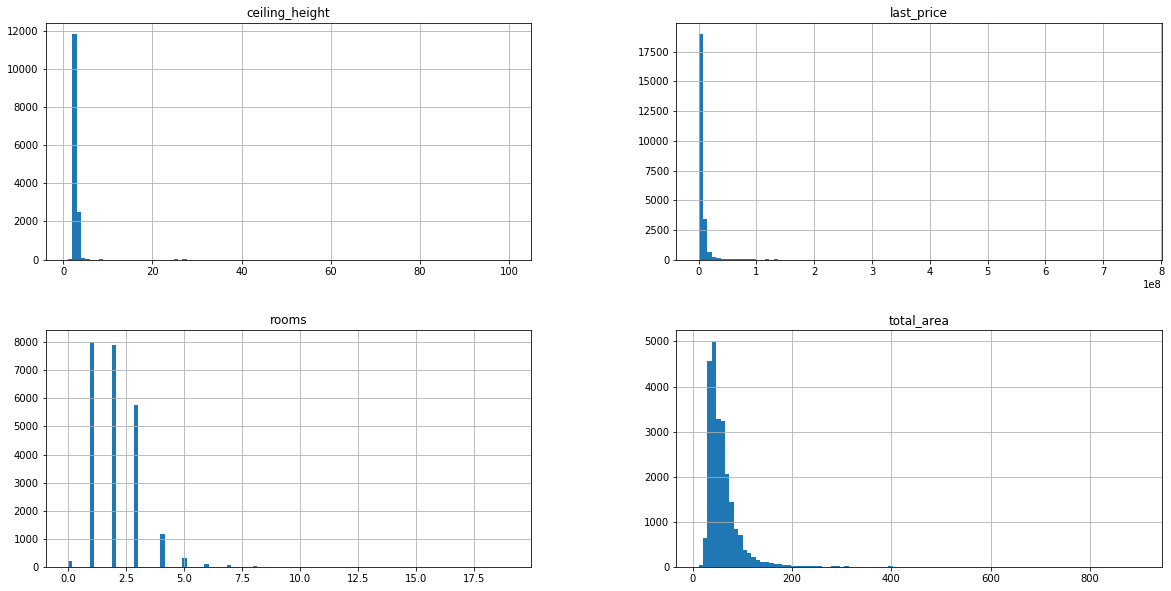

In [58]:
hist_needed = ['total_area', 'last_price', 'rooms', 'ceiling_height']
estate_data[hist_needed].hist(bins = 100);

In [59]:
estate_data[hist_needed].describe()

,total_area,last_price,rooms,ceiling_height
count,23562.000000,2.356200e+04,23562.000000,14428.000000
mean,60.198050,6.509304e+06,2.067864,2.771053
std,35.540499,1.086884e+07,1.077579,1.264149
min,12.000000,1.219000e+04,0.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.510000
50%,52.000000,4.615000e+06,2.000000,2.650000
75%,69.475000,6.750000e+06,3.000000,2.800000
max,900.000000,7.630000e+08,19.000000,100.000000


Посмотрим на крайние значения отсортированых данных по каждому из интересующих нас столбцов чтобы найти аномалии.

In [60]:
estate_data.sort_values('rooms', ascending=False).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
14498,6,32250000.0,374.6,2018-06-09,19,NaN,5.0,264.5,2,NaN,...,114.0,Санкт-Петербург,,86000.0,5,6,2018,другой,0.706,0.073
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4.0,180.0,4,NaN,...,1365.0,Санкт-Петербург,,105500.0,0,3,2015,последний,0.666,0.048
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,NaN,...,14.0,Санкт-Петербург,,110000.0,3,2,2019,другой,0.693,0.169
20829,6,28659000.0,245.4,2016-03-31,14,NaN,4.0,168.3,2,NaN,...,95.0,Санкт-Петербург,,116500.0,3,3,2016,другой,0.685,0.105
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,NaN,...,418.0,Санкт-Петербург,,68500.0,5,12,2017,другой,0.611,0.045


In [61]:
estate_data.sort_values('last_price', ascending=False).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10.0,250.0,10,NaN,...,33.0,Санкт-Петербург,,1907500.0,5,9,2017,последний,0.624,0.374
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,NaN,...,106.0,Санкт-Петербург,,466500.0,2,12,2017,последний,0.455,0.124
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9.0,204.0,9,False,...,393.0,Санкт-Петербург,,1000500.0,5,2,2016,последний,0.508,0.059
1436,19,330000000.0,190.0,2018-04-04,3,3.5,7.0,95.0,5,NaN,...,233.0,Санкт-Петербург,,1736500.0,2,4,2018,другой,0.499,0.210
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7.0,258.0,5,NaN,...,111.0,Санкт-Петербург,,485000.0,0,12,2017,другой,0.417,0.113


In [62]:
estate_data.sort_values('total_area', ascending=False).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,NaN,...,106.0,Санкт-Петербург,,466500.0,2,12,2017,последний,0.455,0.124
12859,20,140000000.0,631.2,2019-04-09,7,3.9,4.0,322.3,4,NaN,...,NaN,Санкт-Петербург,,221500.0,1,4,2019,последний,0.510,0.030
3117,19,140000000.0,631.0,2019-03-30,7,NaN,5.0,571.0,5,NaN,...,NaN,Санкт-Петербург,,221500.0,5,3,2019,последний,0.904,0.095
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7.0,258.0,5,NaN,...,111.0,Санкт-Петербург,,485000.0,0,12,2017,другой,0.417,0.113
5358,20,65000000.0,590.0,2019-02-14,15,3.5,6.0,409.0,3,NaN,...,14.0,Санкт-Петербург,,110000.0,3,2,2019,другой,0.693,0.169


In [63]:
estate_data.sort_values('rooms', ascending=True).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
15704,7,2750000.0,32.20,2018-07-05,0,NaN,17.0,19.20,7,NaN,...,4.0,Санкт-Петербург,,85000.0,3,7,2018,другой,0.596,0.403
11382,5,3600000.0,28.00,2017-08-24,0,2.8,25.0,15.00,16,NaN,...,173.0,Санкт-Петербург,,128500.0,3,8,2017,другой,0.535,0.464
21111,13,2050000.0,28.16,2018-03-01,0,NaN,12.0,18.44,5,NaN,...,160.0,Новоселье,городской поселок,72500.0,3,3,2018,другой,0.654,0.345
12412,0,3300000.0,27.00,2017-08-15,0,NaN,25.0,25.00,22,NaN,...,161.0,Санкт-Петербург,,122000.0,1,8,2017,другой,0.925,0.074
16664,12,5799000.0,25.00,2018-07-11,0,3.1,11.0,16.00,7,NaN,...,NaN,Санкт-Петербург,,231500.0,2,7,2018,другой,0.640,0.359


In [64]:
estate_data.sort_values('last_price', ascending=True).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,...,8.0,Санкт-Петербург,,0.0,2,3,2019,последний,0.293,0.371
14911,5,430000.0,54.0,2018-06-26,2,NaN,3.0,NaN,3,NaN,...,44.0,Свирь,поселок станции,7500.0,1,6,2018,последний,NaN,NaN
17456,7,430000.0,30.4,2019-04-22,1,NaN,2.0,16.0,1,NaN,...,NaN,Сланцы,,14000.0,0,4,2019,первый,0.526,0.197
16274,18,440000.0,40.0,2018-07-10,1,NaN,5.0,NaN,1,NaN,...,45.0,Старополье,деревня,11000.0,1,7,2018,первый,NaN,NaN
5698,7,450000.0,42.0,2017-07-31,2,NaN,1.0,23.0,1,NaN,...,233.0,Будогощь,городской поселок,10500.0,0,7,2017,последний,0.547,0.138


In [65]:
estate_data.sort_values('total_area', ascending=True).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5.0,10.0,2,NaN,...,200.0,Санкт-Петербург,,200000.0,2,7,2017,другой,0.833,0.166
17961,3,1400000.0,13.0,2017-12-03,1,2.60,9.0,NaN,1,NaN,...,410.0,Санкт-Петербург,,107500.0,6,12,2017,первый,NaN,NaN
19807,0,3800000.0,13.0,2018-07-04,1,NaN,5.0,10.0,3,NaN,...,9.0,Санкт-Петербург,,292000.0,2,7,2018,другой,0.769,0.230
19546,3,1850000.0,13.0,2019-03-11,1,3.40,5.0,NaN,2,False,...,24.0,Санкт-Петербург,,142000.0,0,3,2019,другой,NaN,NaN
19558,2,1686000.0,13.2,2018-12-17,1,NaN,5.0,NaN,1,NaN,...,19.0,Санкт-Петербург,,127500.0,0,12,2018,первый,NaN,NaN


Как видно у всех гистограмм имеется очень большой хвост. Однако, в случае рынка недвижимости эти данные в столбцах 'total_area', 'last_price' и 'rooms' не являются выбросами. Как видно, данные всех этих столбцов просто являются данными о продаже очень больших и дорогих квартир, поэтому нет смысла предполагать, что с ними что-то не так, однако для анализа нам стоит удалить их как редкие и выбивающиеся. Для цены такой величиной будет полтора СКО от медианы.

In [66]:
estate_data['last_price'].median()

4615000.0

In [67]:
estate_data['last_price'].median()+1.5*estate_data['last_price'].std()

20918256.86217037

In [68]:
estate_data.drop(estate_data[estate_data['last_price']>20000000].index, axis=0, inplace=True)

In [69]:
estate_data.drop(estate_data[estate_data['rooms']>8].index, axis=0, inplace=True)

In [70]:
estate_data.drop(estate_data[estate_data['total_area']>300].index, axis=0, inplace=True)

Нулевое, количество комнат может указывать на то, что данная квартира - студия 

In [71]:
estate_data[estate_data['studio']==True].sort_values('rooms', ascending=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
144,1,2450000.0,27.00,2017-03-30,0,NaN,24.0,15.50,2,NaN,...,181.0,Мурино,поселок,90500.0,3,3,2017,другой,0.574,0.425
17483,14,4100000.0,26.00,2017-11-26,0,NaN,7.0,17.90,3,NaN,...,30.0,Санкт-Петербург,,157500.0,6,11,2017,другой,0.688,0.311
17452,4,2580000.0,26.23,2018-08-09,0,NaN,15.0,18.00,5,NaN,...,35.0,Мурино,поселок,98000.0,3,8,2018,другой,0.686,0.313
17449,20,1950000.0,28.20,2018-08-28,0,2.8,9.0,22.90,4,NaN,...,NaN,Никольское,,69000.0,1,8,2018,другой,0.812,0.187
17380,3,3400000.0,26.80,2018-01-15,0,NaN,24.0,16.00,19,NaN,...,22.0,Санкт-Петербург,,126500.0,0,1,2018,другой,0.597,0.402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,13,3800000.0,27.00,2016-05-17,1,NaN,14.0,18.00,8,False,...,45.0,Санкт-Петербург,,140500.0,1,5,2016,другой,0.666,0.333
2389,5,2250000.0,25.41,2016-06-07,1,NaN,12.0,17.08,8,False,...,26.0,Санкт-Петербург,,88500.0,1,6,2016,другой,0.672,0.327
20086,0,1550000.0,22.00,2016-05-11,1,2.7,15.0,10.94,14,False,...,45.0,Никольское,,70000.0,2,5,2016,другой,0.497,0.502
12935,10,2200000.0,31.00,2016-05-15,1,2.5,8.0,22.30,5,False,...,44.0,Никольское,,70500.0,6,5,2016,другой,0.719,0.280


Видно, что для студий некоторые указывают количество комнат как 0 или 1. Правильно бы было привести все к одному значению, нулю, чтобы отличать студии от однокомнатных квартир.

In [72]:
estate_data.loc[estate_data['studio']==True, 'rooms'] = 0

In [73]:
estate_data[estate_data['studio']==True]['total_area'].min()

15.5

Так же обратим внимание на то, что минимальное значение площади студии 15.5 квадратных метра. Это дает основание предполагать, что в объявлениях, где площадь ещё меньше, люди или не указали, что квартира является студией, или ошиблись с площадью

In [74]:
estate_data[estate_data['total_area']<15]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
17961,3,1400000.0,13.0,2017-12-03,1,2.60,9.0,NaN,1,NaN,...,410.0,Санкт-Петербург,,107500.0,6,12,2017,первый,NaN,NaN
19546,3,1850000.0,13.0,2019-03-11,1,3.40,5.0,NaN,2,False,...,24.0,Санкт-Петербург,,142000.0,0,3,2019,другой,NaN,NaN
19558,2,1686000.0,13.2,2018-12-17,1,NaN,5.0,NaN,1,NaN,...,19.0,Санкт-Петербург,,127500.0,0,12,2018,первый,NaN,NaN
19642,5,1190000.0,14.0,2018-07-29,1,NaN,5.0,11.0,1,NaN,...,4.0,Санкт-Петербург,,85000.0,6,7,2018,первый,0.785,0.142
19807,0,3800000.0,13.0,2018-07-04,1,NaN,5.0,10.0,3,NaN,...,9.0,Санкт-Петербург,,292000.0,2,7,2018,другой,0.769,0.230
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5.0,10.0,2,NaN,...,200.0,Санкт-Петербург,,200000.0,2,7,2017,другой,0.833,0.166


In [75]:
estate_data['price_per_area'].median()

94000.0

Таких записей всего 6, и, судя по черезмерно большой для студии цене за квадратный метр, ошибка тут все же в площади, поэтому удалим эти столбцы из рассмотрения, чтобы они не мешали анализу.

In [76]:
estate_data.drop(estate_data[estate_data['total_area']<15].index, axis=0, inplace=True)

Так же выделяется квартира с самой маленькой ценой, всего 12190, да еще и в Санкт-Петербурге (остальные сверхнизкие значения в целом адекватны, начинаются от 430000 и располагаются в деревнях. Удалим так же и эту запись. (хотя возмножно, что по ошибке значение этой записи представлено в тысячах. Цена в 12190000 при данных параметрах является вполне адекватной)

In [77]:
estate_data.drop(8793, axis=0, inplace=True)

Посмотрим внимательнее на график распределения высоты потолков. 

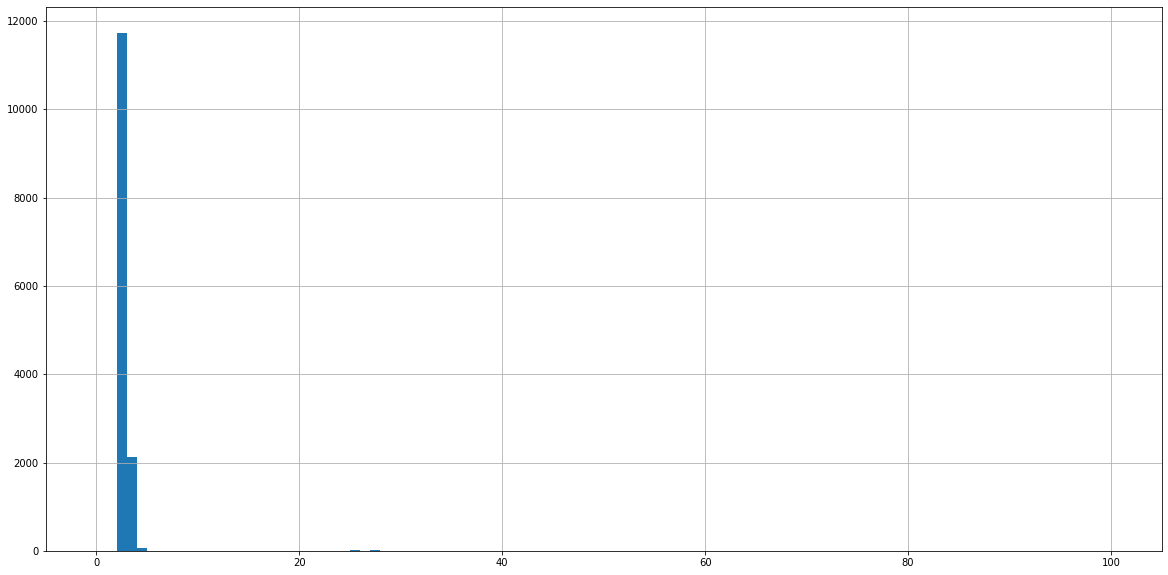

In [78]:
estate_data['ceiling_height'].hist(bins=100, range=(0,100));

Еще внимательнее.

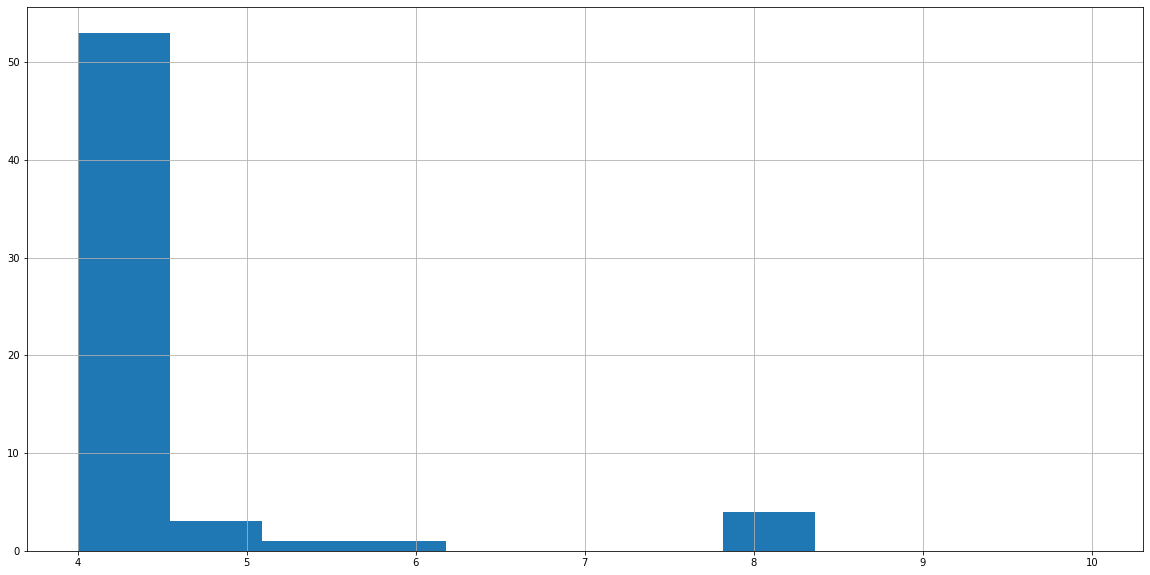

In [79]:
estate_data['ceiling_height'].hist(bins=11, range=(4,10));

Проверим значения в 6 и 8 метров.

In [80]:
estate_data[estate_data['ceiling_height']==6]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total


Вполне можно поверить, что квартира стоимостью 119 миллионов может иметь потолки в 6 метров

In [81]:
estate_data[estate_data['ceiling_height']==8]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,locality_only_name,locality_type,price_per_area,day_of_week,month_exposition,year_exposition,floor_type,living_per_total,kitchen_per_total
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,125.0,Нурма,деревня,46500.0,4,3,2018,другой,0.509,0.243
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,NaN,...,474.0,Санкт-Петербург,,83500.0,4,11,2016,первый,0.611,0.119
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,NaN,...,469.0,Красное Село,,99000.0,1,6,2015,другой,0.537,0.462


А вот это уже точно ошибка. Удалим все записи, значение высоты потолков в которых превышает 6 метров.

In [82]:
estate_data.drop(estate_data[estate_data['ceiling_height']>6].index, axis=0, inplace=True)

Плюс, как мы уже сказали, по СНиП минимальная высота потолков 2,5 метров, поэтому удвлим все (достаточно редкие) записи, в которых эта высота значительно меньше

In [83]:
estate_data.drop(estate_data[estate_data['ceiling_height']<2.4].index, axis=0, inplace=True)

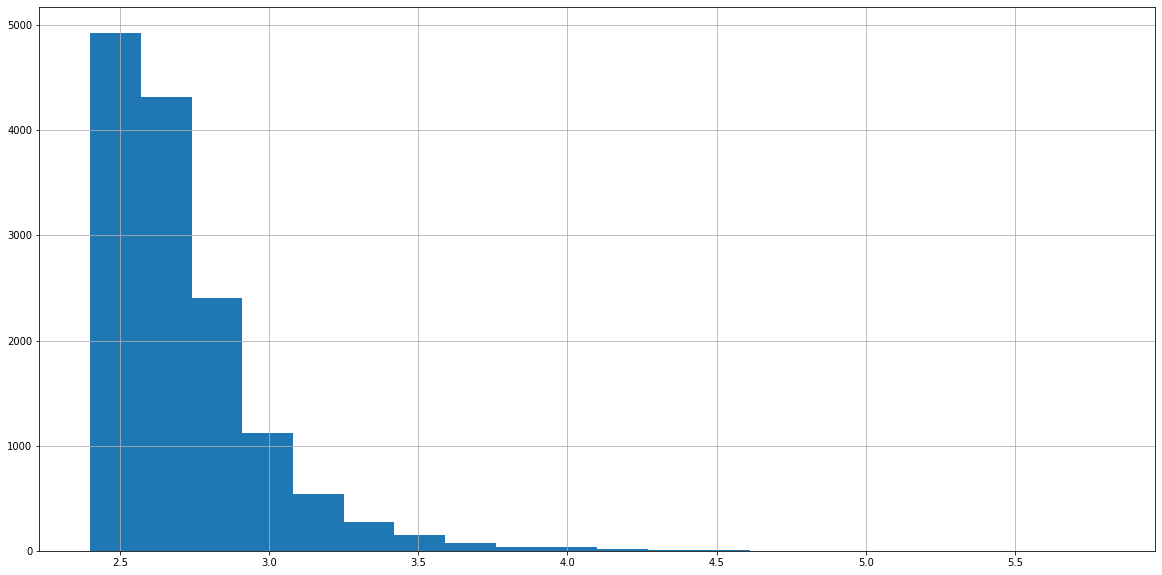

In [84]:
estate_data['ceiling_height'].hist(bins=20);

Теперь график выглядит так, как можно было бы от него ожидать.

2. **Время продажи квартиры**

Выведем основные параметры столбца 'days_exposition'

In [85]:
estate_data['days_exposition'].describe()

count    19850.000000
mean       174.119244
std        209.545024
min          1.000000
25%         44.000000
50%         93.000000
75%        223.000000
max       1512.000000
Name: days_exposition, dtype: float64

In [86]:
estate_data['days_exposition'].median()

93.0

Среднее значение практически в два раза превышает медиану, это значит что большой эффект на среднее оказывает хвост из очень высоких значений.  

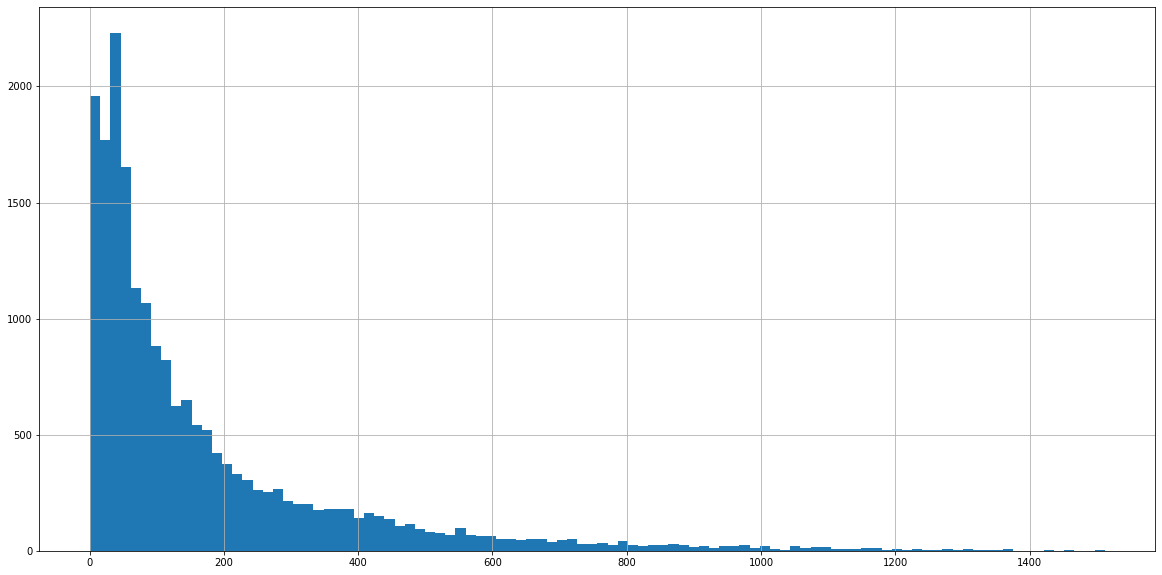

In [87]:
estate_data['days_exposition'].hist(bins=100);

Возможно это значени уже проданых квартир, объявления о которых не были удалены. Так или иначе представлятся малореальным, что квартиру могли бы продавать больше года. Медианное значение тут хорошо описывает реальное среднее время, за которое квартиру возможно продать.  
При этом записей, значения которых сильно превышают реальные очень много, и было бы обидно лишаться необходимых для дальшейшего анализа данных. 

Можно убрать значения, которые отличаются от медианы больше чем на полтора СКО. 

In [88]:
estate_data['days_exposition'].median()+1.5*estate_data['days_exposition'].std()

407.3175363182677

In [89]:
estate_data[estate_data['days_exposition']>425]['days_exposition'].count()

2138

In [90]:
estate_data.drop(estate_data[estate_data['days_exposition']>425].index, axis=0, inplace=True)

Теперь данные выглядят так

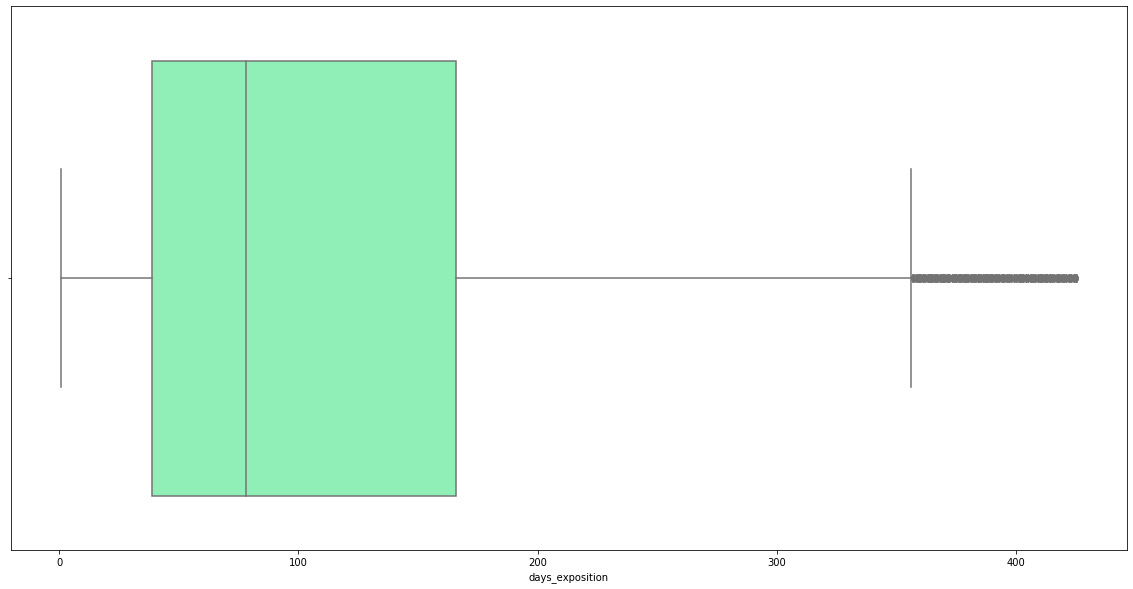

In [91]:
sns.boxplot(x="days_exposition", data=estate_data, palette='rainbow');

3. **Какие факторы больше всего влияют на стоимость квартиры?**

Построим графики совместного распределения целевых величин

In [92]:
targer_columns=['last_price', 'total_area', 'rooms', 'cityCenters_nearest']

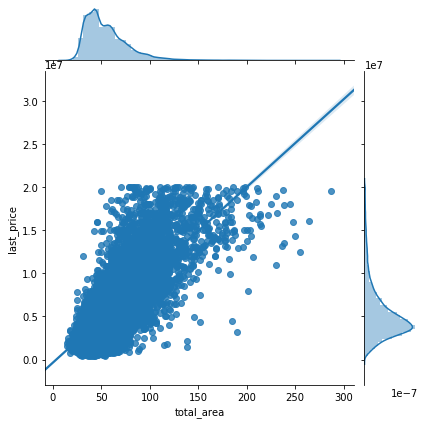

In [93]:
sns.jointplot(x='total_area', y='last_price', data=estate_data, kind='reg');

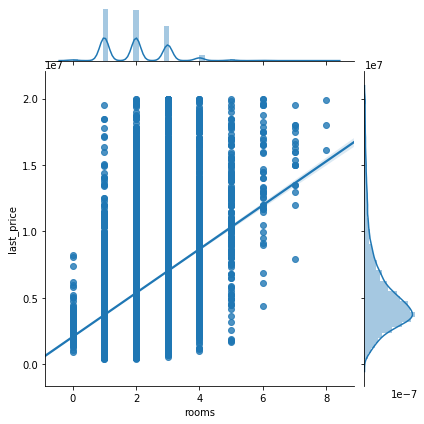

In [94]:
sns.jointplot(x='rooms', y='last_price', data=estate_data, kind='reg');

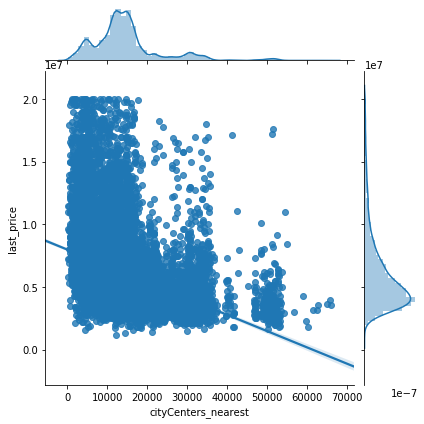

In [95]:
sns.jointplot(x='cityCenters_nearest', y='last_price', data=estate_data, kind='reg');

Посчитаем матрицу корреляции для целевых параметров

In [96]:
estate_data[targer_columns].corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.770977,0.508572,-0.347832
total_area,0.770977,1.000000,0.794672,-0.190503
rooms,0.508572,0.794672,1.000000,-0.135638
cityCenters_nearest,-0.347832,-0.190503,-0.135638,1.000000


Для наглядности построим тепловую карту по всем параметрам

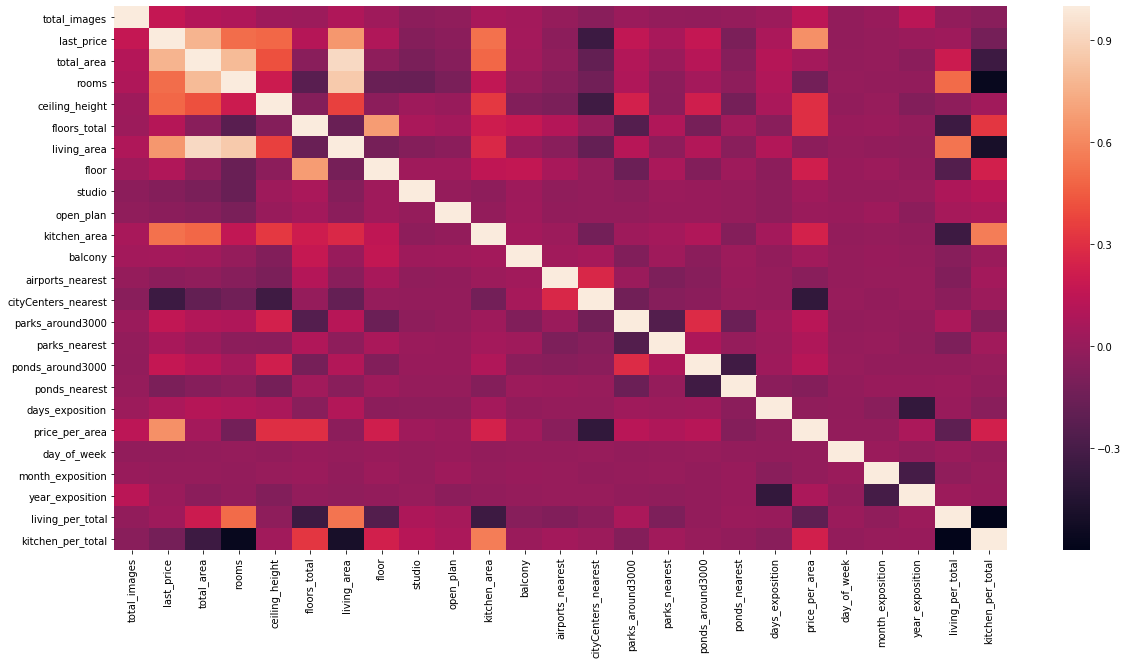

In [97]:
sns.heatmap(estate_data.corr());

Как можно заметить, итоговая цена имеет высокий линейный коэффициент корреляции с площадью. Число комнат, в свою очередь, так же линейно зависит от площади (ведь как правило чем больше площадь квартиры, тем больше в ней комнат). Из тепловой карты можно сделать вывод, что основным параметром, влияющим на стоимость квартиры, является её площадь. Все остальные параметры, показывающие корреляцию, линейно зависимы.  

Коэффициент корреляции цены и расстояния до центра меньше, по причине того, что зависимость между этими параметрами нелинейная. Так как факторной переменной соответствует замедленное убывание результативной зависимость вероятнее всего гиперболическая. (при этом явно заметен тренд на уменьшение цены при удалениии от центра)

Построим график зависимости цены от типа этажа

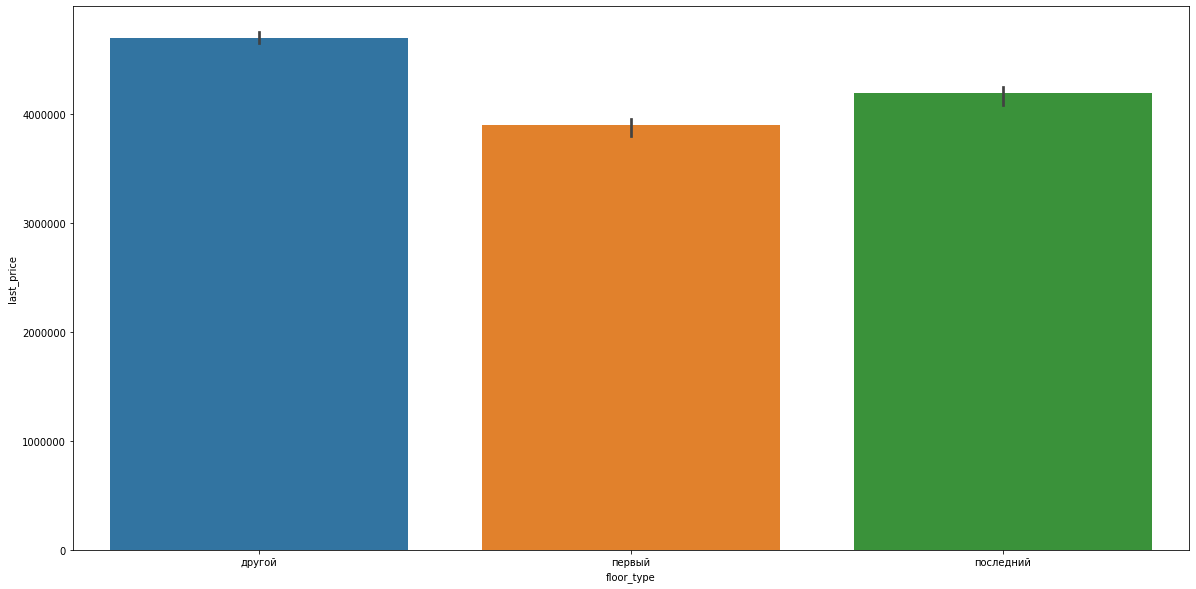

In [98]:
sns.barplot(x='floor_type', y='last_price', data=estate_data, estimator=np.median);

Цена на первых этажах как правило ниже чем на других (это понятно, не многие хотят, чтобы им в окна заглядывали прохожие, из подвала прибегали крысы, а сама квартира служила легкой мишенью для грабителей). Последние этажи тоже стоят дешевле, хотя и не так сильно как первые. Это можно объяснить тем, что построеннные в советское время дома не всегда отличались высоким качеством кровли и имелась опасность протечек. Данные соответствуют реальности, "Первый и последний этажи не предлагать" - традиционная фраза для объявлений о покупке квартир.
На вторичном рынке Москвы стоимость квартир на последнем этаже обычно на 5% ниже, чем средняя цена жилья в том же самом доме:
https://realty.rbc.ru/news/587ddad69a79474f1cded0df

Построим графики зависимости цены от дня недели 

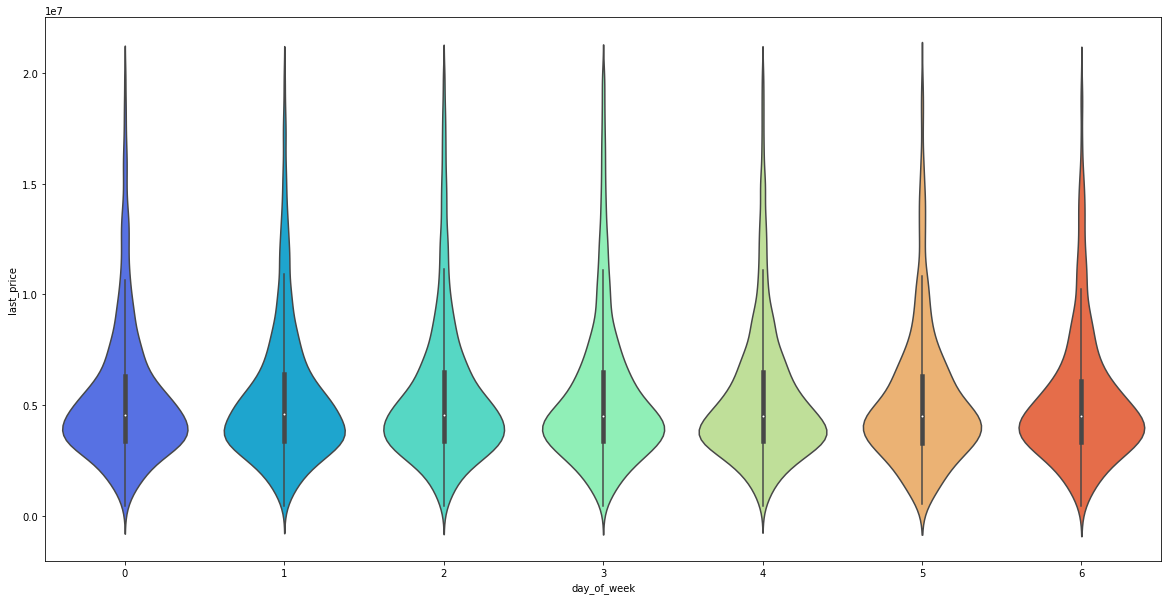

In [99]:
sns.violinplot(x="day_of_week", y="last_price", data=estate_data, palette='rainbow');

Как видно цена в зависимости от дня недели значительно не изменяется

Построим столбчатые диаграммы зависимости цены от года и месяца

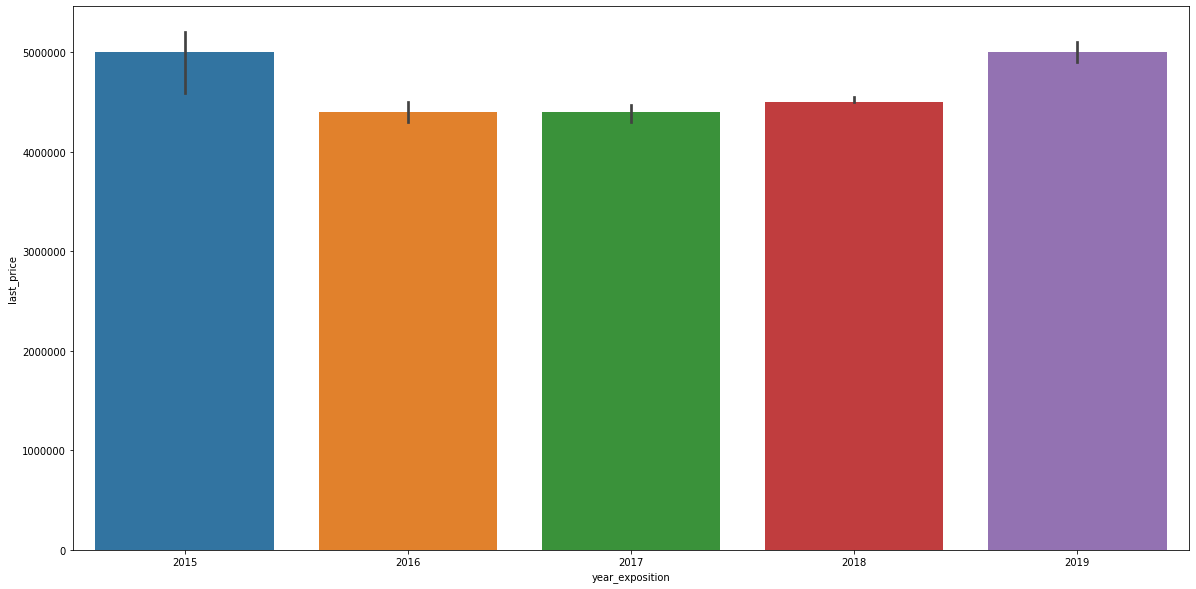

In [100]:
sns.barplot(x='year_exposition', y='last_price', data=estate_data, estimator=np.median);

Видно, что медианная цена на недвижимость в 2015 году была выше, однако это можно объяснить недостатком данных (записей для 2015 года у нас немного). Данные за 2019 год тоже представлены только на начало года, однако можно заметить, что с 2017 года стоимость недвижимости начинает расти.

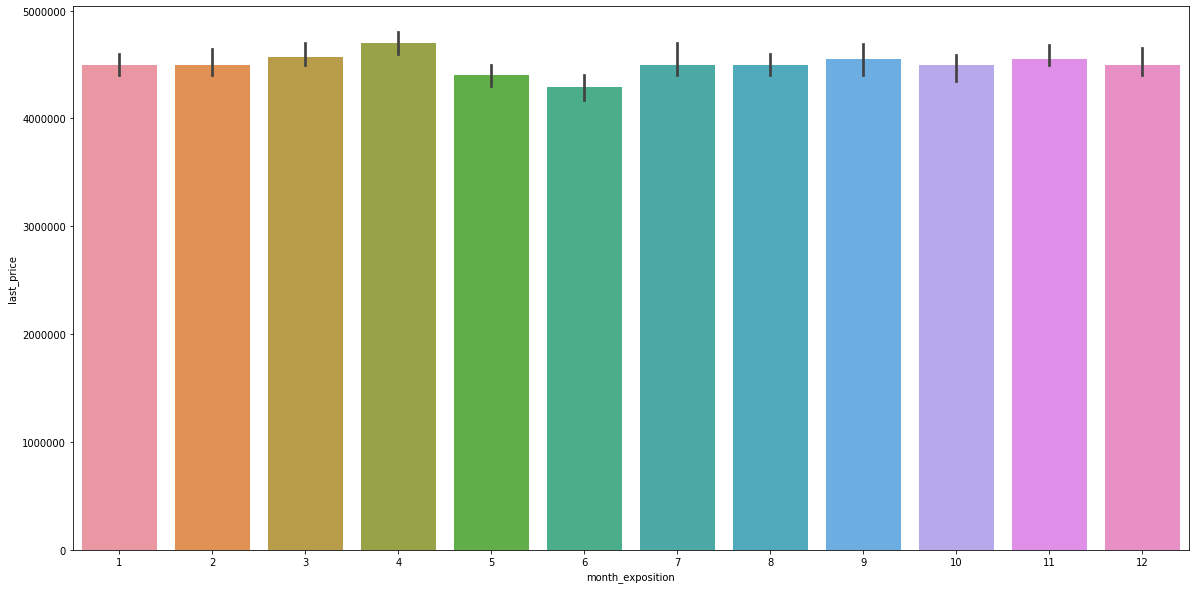

In [101]:
sns.barplot(x='month_exposition', y='last_price', data=estate_data, estimator=np.median);

Данные продаж по месяцам тоже ровные, наблюдается некоторое незначительное повышение медианной цены в апреле и снижение её в мае и июне

Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

4. **10 населённых пунктов с наибольшим числом объявлений**

Считать населенные пункты будем по столбцу 'locality_only_name'

In [102]:
estate_data['locality_only_name'].value_counts().head(10)

Санкт-Петербург    13487
Мурино               543
Кудрово              427
Шушары               406
Всеволожск           353
Пушкин               327
Колпино              315
Парголово            300
Гатчина              272
Выборг               212
Name: locality_only_name, dtype: int64

<details>
  <summary>Спойлер</summary>
  <p>
        (Кстати, все эти населенные пункты кроме Выборга, Всеволжска и Гатчины - части Санкт-Петербурга. Они либо являются внутригородскими муниципальными образованиями как Шушары, либо воспринимаются частью Питера даже относясь к Ленобласти, как Мурино. И метро в Мурино появилось даже раньше чем в Шушарах)

Построем сводную таблицу для определения средней цены квадратного метра

In [103]:
top_10_loc = estate_data[estate_data['locality_only_name'].isin(list((estate_data['locality_only_name'].value_counts().head(10).index)))]

In [104]:
top_10_loc.pivot_table(index='locality_only_name', values='price_per_area', aggfunc=['mean', 'count'])

,mean,count
,price_per_area,price_per_area
locality_only_name,,
Всеволожск,67158.640227,353
Выборг,58120.283019,212
Гатчина,68777.573529,272
Колпино,75049.206349,315
Кудрово,95411.007026,427
Мурино,86101.289134,543
Парголово,89515.000000,300
Пушкин,101542.813456,327


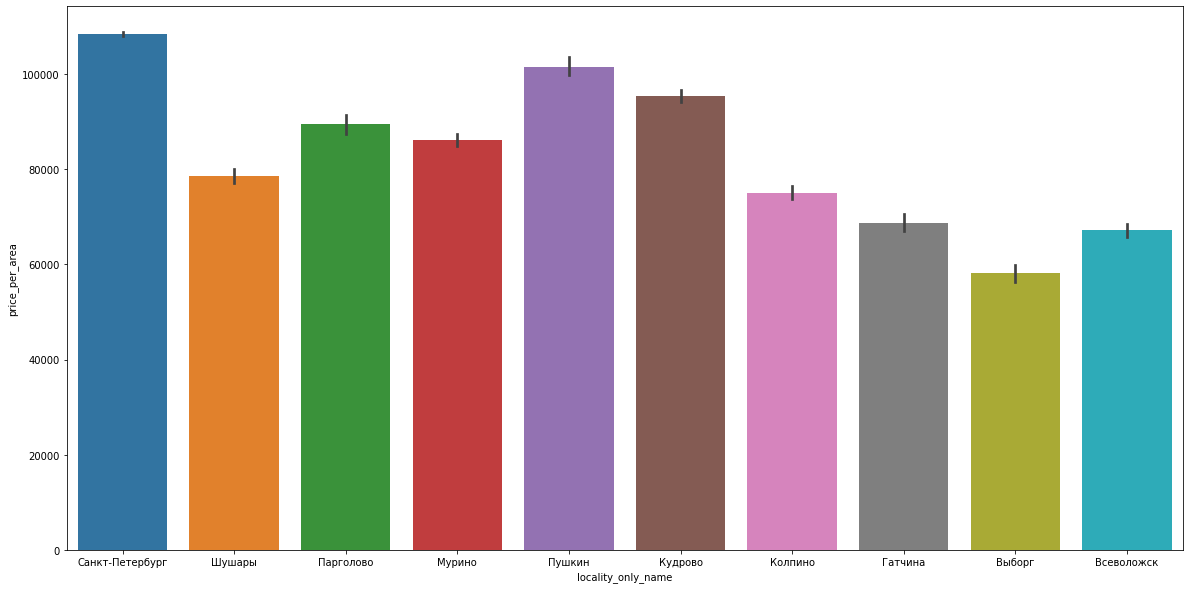

In [105]:
sns.barplot(x='locality_only_name', y='price_per_area', data=top_10_loc, estimator=np.mean);

Самая высокая стоимость квадратного метра жилья ожидаемо оказалась в Санкт-Петербурге.   
На втором месте распологается Пушкин, административно являющейся городом в составе Петербурга, имеющий, однако, сомнительную транспортную доступность, но хорошую экологию, парки, малоэтажную застройку.  
Далее следует Кудрово ~~(не покупайте там квартиру никогда)~~, современный район с развивающейся инфраструктурой и планами по строительству метрополитена. (а еще в пределах КАДа)  
3 и 4 места делят Парголово и Мурино (метро Парнас и Девяткино соответственно) - районы новостроек в которые никогда не пришел бы Варламов, самые популярные места для покупки недорогой недвижимости, большим плюсом районов является метро.  
Шушары - район новостроек на юге петербурга, развивавшейся не так активно ввиду отсутствия метро, которое было открыто в середине 2019 года, уже после сбора данных, так что есть оснавание предполагать, что сейчас стоимость жилья там выросла.  
Колпино, Гатчина и Всеволжск - пригороды Петербурга, дачи, цена надвижимости там невысока, а добираться до города приходится на электричке.  
Самая низкая цена - в Выборге (который находится чуть более чем в 100 км от Питера).

5. **Категоризация квартир по расстоянию.**

Создадим столбец с расстоянием до центра в километрах, округлив его до целых

In [106]:
estate_data['center_nearest'] = estate_data['cityCenters_nearest'] / 1000

In [107]:
estate_data['center_nearest'] = round(estate_data['center_nearest'])

In [108]:
spb_distance_range = estate_data[estate_data['locality_name']=='Санкт-Петербург'].pivot_table(index='center_nearest', values='last_price', aggfunc=['mean', 'count'])

In [109]:
spb_distance_range

,mean,count
,last_price,last_price
center_nearest,,
0.0,1.009846e+07,13
1.0,1.074336e+07,116
2.0,1.005168e+07,217
3.0,8.927028e+06,274
4.0,9.273747e+06,501
5.0,9.307243e+06,649
6.0,8.521646e+06,447
7.0,7.803129e+06,311


In [110]:
spb_distance_range.columns = ['mean_price', 'count']

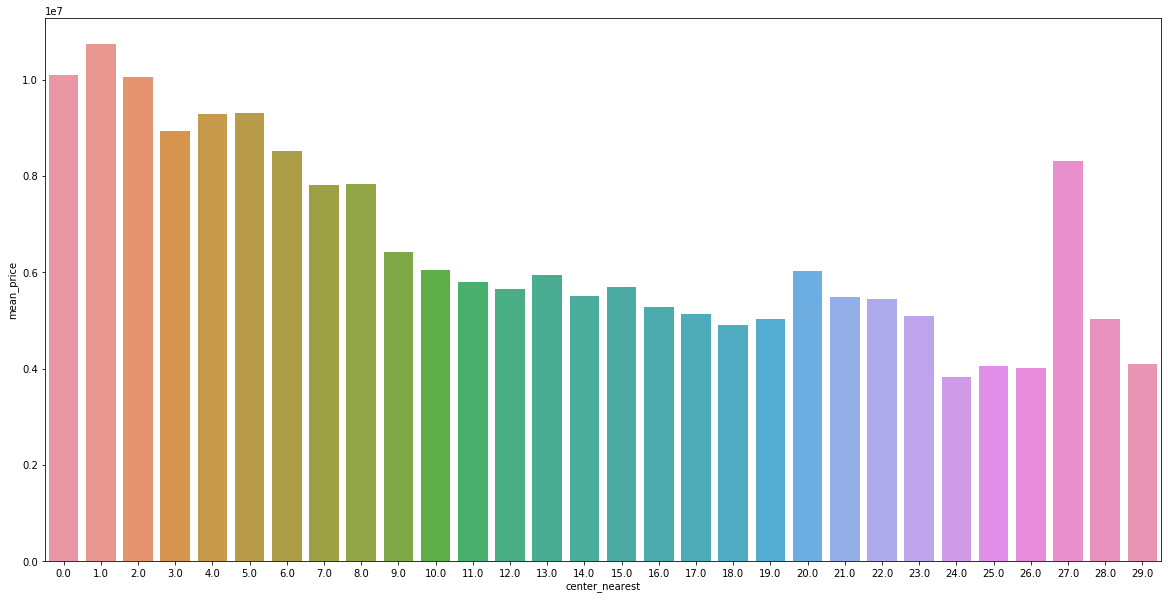

In [111]:
sns.barplot(x=spb_distance_range.index, y='mean_price', data=spb_distance_range, estimator=np.mean);

Видно что с увеличением расстояния от центра стоимость квартир падает. (выброс на расстаянии в 27 км формируют всего 2 записи. На этом расстоянии находится Сестрорецк, и вероятнее всего высокая цена образуется из-за элитных частных домов Курортного района). На расстоянии 3-5 км стоимость квартир несколько повышается, именно на этом расстоянии от центра находитя Крестовский остров с дорогими квартирами.   
Если проигнорировать эти значения, график значительно менятся при переходе от 2 к 3 км. Имеет смысл принять центральную зону радиусом 2,5 км

6. **Анализ квартир центральной зоны** 

Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

Создадим столбец, сообщающий, является ли зона центральной

In [112]:
estate_data['is_center'] = pd.to_numeric(estate_data['cityCenters_nearest']<=2500)

In [113]:
hist_needed = ['total_area', 'last_price', 'rooms', 'ceiling_height']

In [114]:
estate_data.pivot_table(index = 'is_center', values = hist_needed, aggfunc = 'mean', margins = True)

,ceiling_height,last_price,rooms,total_area
is_center,,,,
False,2.695396,5.271630e+06,1.975451,55.546528
True,3.210289,1.029010e+07,2.899135,85.656110
All,2.705334,5.582014e+06,2.047532,57.154103


Выведем соответствующие графики.

In [115]:
plt.rcParams['figure.figsize'] = (5.0, 3.0)

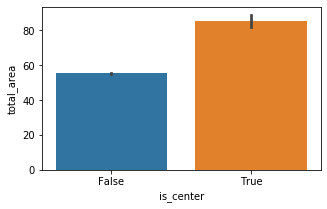

In [116]:
sns.barplot(x='is_center', y='total_area', data=estate_data, estimator=np.mean);

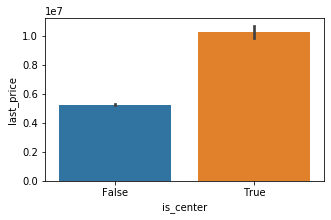

In [117]:
sns.barplot(x='is_center', y='last_price', data=estate_data, estimator=np.mean);

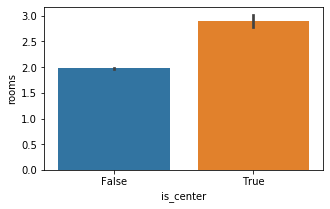

In [118]:
sns.barplot(x='is_center', y='rooms', data=estate_data, estimator=np.mean);

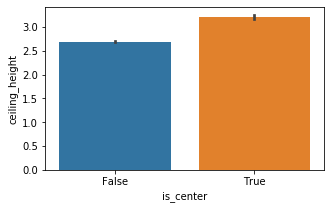

In [119]:
sns.barplot(x='is_center', y='ceiling_height', data=estate_data, estimator=np.mean);

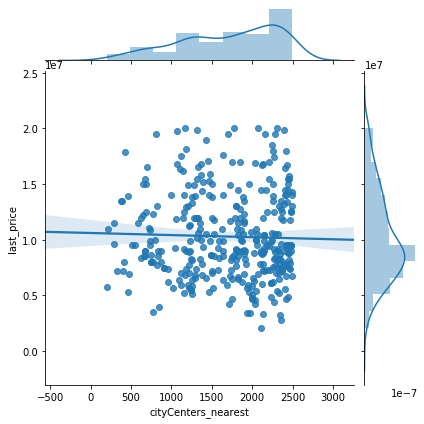

In [120]:
sns.jointplot(x='cityCenters_nearest', y='last_price', data=estate_data[estate_data['is_center']==True], kind='reg');

Можно увидеть, что в центре и количество комнат, и площадь, и даже высота потолков выше чем в целом по городу, хотя и не сильно значительно. При этом средняя цена за квартиру в центре превышает среднюю по городу практически в 2 раза. Значит сам факт того, что квартира находится в центре повышает её ценность.

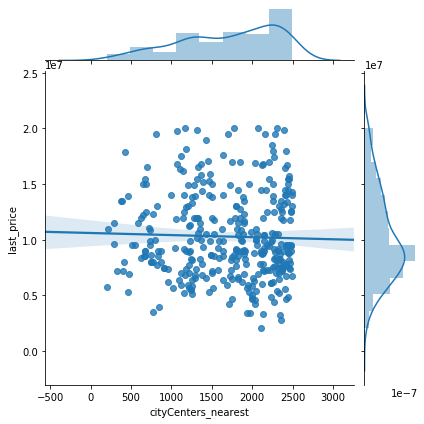

In [121]:
sns.jointplot(x='cityCenters_nearest', y='last_price', data=estate_data[estate_data['is_center']==True], kind='reg');

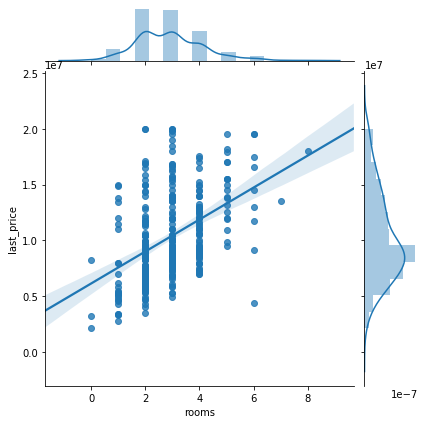

In [122]:
sns.jointplot(x='rooms', y='last_price', data=estate_data[estate_data['is_center']==True], kind='reg');

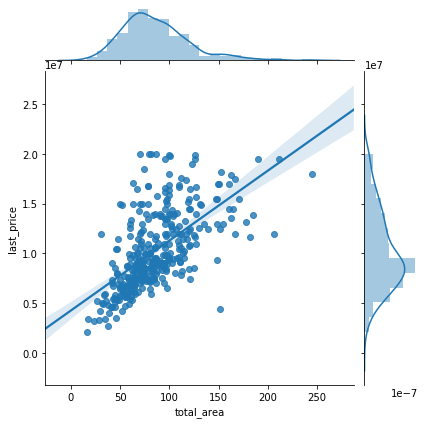

In [123]:
sns.jointplot(x='total_area', y='last_price', data=estate_data[estate_data['is_center']==True], kind='reg');

In [124]:
estate_data[estate_data['is_center']==True][targer_columns].corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.611529,0.441212,-0.029083
total_area,0.611529,1.000000,0.791757,0.012480
rooms,0.441212,0.791757,1.000000,0.018493
cityCenters_nearest,-0.029083,0.012480,0.018493,1.000000


В центре стоимость квартиры все так же зависит от площади и количества комнат, а вот расстояние до центра практически перестает играть роль.

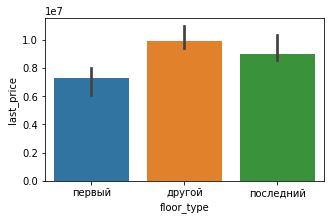

In [125]:
sns.barplot(x='floor_type', y='last_price', data=estate_data[estate_data['is_center']==True], estimator=np.median);

В центре как и в остальном городе люди предпочитают не селиться на первых и послежних этажах.

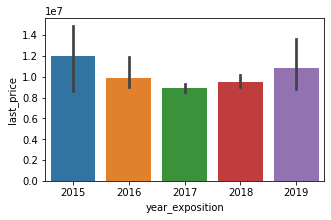

In [126]:
sns.barplot(x='year_exposition', y='last_price', data=estate_data[estate_data['is_center']==True], estimator=np.median);

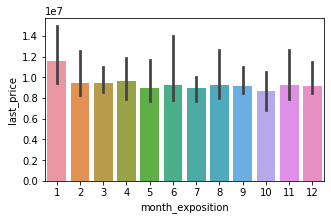

In [127]:
sns.barplot(x='month_exposition', y='last_price', data=estate_data[estate_data['is_center']==True], estimator=np.median);

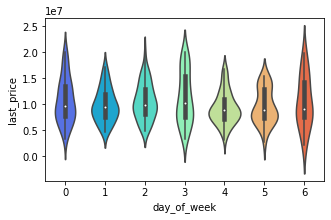

In [128]:
sns.violinplot(x="day_of_week", y="last_price", data=estate_data[estate_data['is_center']==True], palette='rainbow');

Графики по дням недели, месяцам и годам в целом соответствуют таким же графикам для всего остального города.

### Шаг 5. Общий вывод

На основании сведений сервиса Яндекс.Недвижимость были проанализированы параметры, необходимые для определения стоимости недвижимости.   

Были обнаружены ошибки в автоматическом определении картографических данных (необходимо сообщить об этом для дальшейшего исправления). Часть пропущеных значений была востановлена по имеющимся, часть - проигнорирована, так как пропуски не являются критическими для анализа с помощью графиков. Критические и аномальные значения из рассмотрения были удалены.  

Изучены параметры, от которых зависит стоимость квартиры. Выявлено, что сильнее всего стоимость коррелирует с площадью квартиры (многие другие параметры, которые показывают корреляцию с ценой линейно зависят от площади). Важным параметром является так же расстояние от центра, при этом зависимость эта нелинейная. 

Для города Санкт-Петербурга был выявлен и проанализирован центральный сегмент. Стоимость квартир в нем значительно превышает ту, которую можно ожидать исходя из её площади. Это занчит что отнесение квартиры к центру само по себе является важным параметром для ценообразования.